In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from models.simple_cnn import SimpleCNN

from helpers.helpers import SequenceDataset

from torch.utils.data import DataLoader

from ray import tune
from ray.tune.schedulers import ASHAScheduler

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

# Load the data
def load_dataframe(data_df=None):
    if data_df is not None:
        return data_df
    data_df = pd.read_csv('combined_data.csv')
    # get mean of each stress condition
    averages_df = data_df.copy()
    stress_conditions = set([name.split('_')[0] for name in data_df.columns if 'TPM' in name])
    for stress in stress_conditions:
        stress_columns = [name for name in data_df.columns if stress+'_' in name]
        averages_df[f'{stress}'] = np.mean([data_df[stress_columns[0]], data_df[stress_columns[1]], data_df[stress_columns[2]]], axis=0)

    # Drop the columns that are not needed
    averages_df = averages_df.drop(columns=[name for name in averages_df.columns if 'TPM' in name] + ['Chromosome','Region','Species', 'Unnamed: 0'])
    # drop rows with missing upstream200 sequences
    averages_df = averages_df.dropna(subset=['upstream200'])
    # drop rows with upstream200 sequences that contain anything but A, T, C, G
    averages_df = averages_df[averages_df['upstream200'].apply(lambda x: set(x).issubset({'A', 'T', 'C', 'G'}))]


    mlb = MultiLabelBinarizer()
    # map each species id to a one hot encoding
    averages_df['Species ID'] = averages_df['Species ID'].apply(lambda x: [x])
    averages_df['Species ID'] = mlb.fit_transform(averages_df['Species ID']).tolist()

    # map each base to one hot encoding
    base_encodings = {'A': [1,0,0,0], 'T': [0,1,0,0], 'C': [0,0,1,0], 'G': [0,0,0,1]}
    longest_sequence = max(averages_df['upstream200'].apply(lambda x: len(x)))
    averages_df['upstream200'] = averages_df['upstream200'].apply(lambda x: [base_encodings[base] for base in x] + [[0,0,0,0]]*(longest_sequence-len(x)))

    # explode dataset to have one row per stress condition
    averages_df['Stress'] = averages_df.apply(lambda row: [{stress:row[stress]} for stress in stress_conditions], axis=1)
    averages_df = averages_df.drop(columns=[name for name in averages_df.columns if name in stress_conditions])

    averages_df = averages_df.explode('Stress')
    averages_df['Stress_name'] = averages_df['Stress'].apply(lambda x: list(x.keys())[0])
    averages_df['Stress'] = averages_df['Stress'].apply(lambda x: list(x.values())[0])

    # one hot encode stress names
    averages_df['Stress_name'] = averages_df['Stress_name'].apply(lambda x: [x])
    averages_df['Stress_name'] = mlb.fit_transform(averages_df['Stress_name']).tolist()

    # drop rows with 0 stress
    averages_df = averages_df[averages_df['Stress'] > 0]

    # log values of stress conditions
    averages_df['Stress'] = averages_df['Stress'].apply(lambda x: np.log(x+1))

    data_df = averages_df
    return averages_df


In [43]:
def load_data(species_id = -1, size = -1 ,val_split = 0.2 , test_split = 0.1, data_df=None):
    data_df = load_dataframe(data_df)
    
    if species_id != -1:
        data_df = data_df[data_df['Species ID'].apply(lambda x: x[species_id] == 1)]
    if size != -1:
        size = int(size * 1.39)
        data_df = data_df.sample(size)

    # split the data into training and testing
    X_train, X_test, y_train, y_test = train_test_split(data_df[['Species ID', 'Stress_name', 'upstream200']], data_df['Stress'], test_size=test_split)

    # create a dataset
    train_dataset = SequenceDataset(X_train, y_train)
    test_dataset = SequenceDataset(X_test, y_test)

    return train_dataset, test_dataset


In [46]:
def train(config):
    net = SimpleCNN(*config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=config['lr'])
    
    train_dataset, test_dataset = load_data(species_id=config['species_id'], size=config['test_size'], data_df=config['data_df'])
    print(f"Training on {len(train_dataset)} samples, testing on {len(test_dataset)} samples")

    train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2)
    
    train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=True)

    train_losses = []
    val_losses = []

    for epoch in range(config['epochs']):
        net.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            inputs, labels = [i.to(device) for i in inputs], labels.to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.cpu().detach().numpy()

        train_losses.append(running_loss/len(train_loader))
        
        net.eval()
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(val_loader, 0):
            inputs, labels = data
            inputs, labels = [i.to(device) for i in inputs], labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.cpu().detach().numpy()
            val_steps += 1

        val_losses.append(val_loss/val_steps)

        print(f"Epoch {epoch}, train loss: {running_loss/len(train_loader)} validation loss: {val_loss/len(val_loader)}")

    return net, train_losses, val_losses



In [48]:
# plot the losses
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()
    plt.show()

    log_train_losses = np.log(train_losses)
    log_val_losses = np.log(val_losses)
    plt.plot(log_train_losses, label='Log Train Loss')
    plt.plot(log_val_losses, label='Log Validation Loss')
    plt.legend()
    plt.show()



In [28]:
data_df = load_dataframe()

In [47]:
config = {
    'lr': 0.0001,
    'batch_size': 2,
    'epochs': 10,
    'species_id': 2,
    'test_size': 2000,
    'data_df': data_df
}

net, train_losses, val_losses = train(config)



Training on 2502 samples, testing on 278 samples


/home/igalutz/.local/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0, train loss: 12.263691382761765 validation loss: 2.1664996353020722
Epoch 1, train loss: 2.059181827434025 validation loss: 2.159921076733144
Epoch 2, train loss: 2.0581380442471837 validation loss: 2.1611095058226883
Epoch 3, train loss: 2.058281383826281 validation loss: 2.151820134074683
Epoch 4, train loss: 2.048012373400489 validation loss: 2.1621959738450056
Epoch 5, train loss: 2.0435461262789936 validation loss: 2.1501141044541274
Epoch 6, train loss: 2.0453068304057225 validation loss: 2.1529917770132156
Epoch 7, train loss: 2.0395130269646287 validation loss: 2.1426095708969757
Epoch 8, train loss: 2.0414750318114065 validation loss: 2.1634162306800424
Epoch 9, train loss: 2.0399444472674118 validation loss: 2.136653916039263


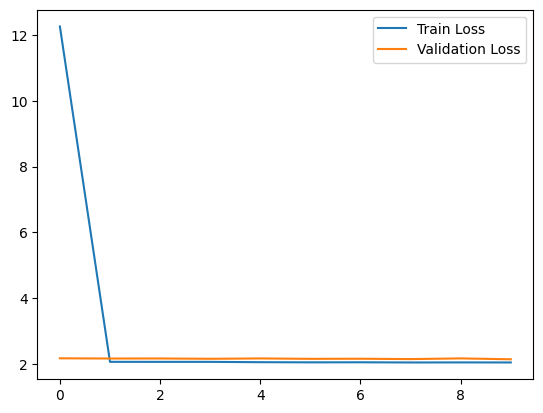

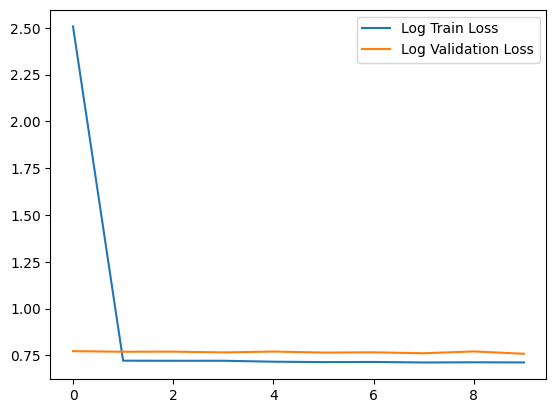

In [49]:
plot_losses(train_losses, val_losses)